# 这一程序有三部分，分别是
### 一.crnn做一到九这九个汉字的模型
### 二.crnn做随机抽取keys中20来个字的模型
### 三.crnn做从keys中挑选255个汉字的模型

### 此程序整个运行耗时2h左右

In [1]:
from modelarts.session import Session
sess = Session()

if sess.region_name == 'cn-north-1':
    bucket_path="modelarts-labs/notebook/DL_ocr_crnn_sequence_recognition/crnn.tar"
elif sess.region_name == 'cn-north-4':
    bucket_path="modelarts-labs-bj4/notebook/DL_ocr_crnn_sequence_recognition/crnn.tar"
else:
    print("请更换地区到北京一或北京四")

sess.download_data(bucket_path=bucket_path, path="./crnn.tar")

Successfully download file modelarts-labs/notebook/DL_ocr_crnn_sequence_recognition/crnn.tar from OBS to local ./crnn.tar


In [2]:
!tar -xf crnn.tar
!pip install keras==2.1.6

You are using pip version 9.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
!pip install captcha

You are using pip version 9.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## 第一部分(crnn做一到九这九个汉字的模型)

In [4]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import string
characters = '一二三四五六七'
print(characters)

width, height, n_len, n_class = 128, 64, 4, len(characters) + 1

一二三四五六七


In [5]:
import tensorflow as tf
import tensorflow.keras.backend as K

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

In [6]:
import tensorflow.keras.backend as K

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [7]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

input_tensor = Input((height, width, 3))
x = input_tensor
for i, n_cnn in enumerate([2, 2, 2, 2, 2]):
    for j in range(n_cnn):
        x = Conv2D(32*2**min(i, 3), kernel_size=3, padding='same', kernel_initializer='he_uniform')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
    x = MaxPooling2D(2 if i < 3 else (2, 1))(x)

x = Permute((2, 1, 3))(x)
x = TimeDistributed(Flatten())(x)

rnn_size = 128
x = Bidirectional(CuDNNGRU(rnn_size, return_sequences=True))(x)
x = Bidirectional(CuDNNGRU(rnn_size, return_sequences=True))(x)
x = Dense(n_class, activation='softmax')(x)

base_model = Model(inputs=input_tensor, outputs=x)

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
labels = Input(name='the_labels', shape=[n_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([x, labels, input_length, label_length])

model = Model(inputs=[input_tensor, labels, input_length, label_length], outputs=loss_out)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


In [9]:
from tensorflow.keras.utils import Sequence

class CaptchaSequence(Sequence):
    def __init__(self, characters, batch_size, steps, n_len, width=128, height=64, 
                 input_length=16, label_length=4):
        self.characters = characters
        self.batch_size = batch_size
        self.steps = steps
        self.n_len = n_len
        self.width = width
        self.height = height
        self.input_length = input_length
        self.label_length = label_length
        self.n_class = len(characters)
        self.generator = ImageCaptcha(width=width, height=height,fonts=ziti)
    
    def __len__(self):
        return self.steps

    def __getitem__(self, idx):
        X = np.zeros((self.batch_size, self.height, self.width, 3), dtype=np.float32)
        y = np.zeros((self.batch_size, self.n_len), dtype=np.uint8)
        input_length = np.ones(self.batch_size)*self.input_length
        label_length = np.ones(self.batch_size)*self.label_length
        for i in range(self.batch_size):
            random_str = ''.join([random.choice(self.characters) for j in range(self.n_len)])
            X[i] = np.array(self.generator.generate_image(random_str)) / 255.0
            y[i] = [self.characters.find(x) for x in random_str]
        return [X, y, input_length, label_length], np.ones(self.batch_size)

Tensor("input_length:0", shape=(?, 1), dtype=int64) Tensor("label_length:0", shape=(?, 1), dtype=int64)


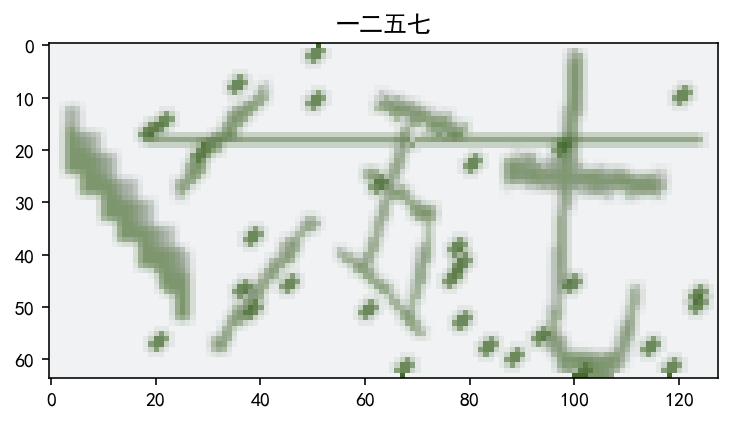

In [10]:
ziti = ['msyhl.ttc']
data = CaptchaSequence(characters, batch_size=1, steps=1,n_len=n_len)
[X_test, y_test, _, _], _  = data[0]
plt.imshow(X_test[0])
plt.title(''.join([characters[x] for x in y_test[0]]))
print(input_length, label_length)

In [11]:
from tqdm import tqdm

def evaluate(model, batch_size=128, steps=20,n_len=n_len):
    batch_acc = 0
    valid_data = CaptchaSequence(characters, batch_size, steps,n_len)
    for [X_test, y_test, _, _], _ in valid_data:
        y_pred = base_model.predict(X_test)
        shape = y_pred.shape
        out = K.get_value(K.ctc_decode(y_pred, input_length=np.ones(shape[0])*shape[1])[0][0])[:, :4]
        if out.shape[1] == 4:
            batch_acc += (y_test == out).all(axis=1).mean()
    return batch_acc / steps

In [12]:
from tensorflow.keras.callbacks import Callback

class Evaluate(Callback):
    def __init__(self):
        self.accs = []
    
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        acc = evaluate(base_model)
        logs['val_acc'] = acc
        self.accs.append(acc)

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from tensorflow.keras.optimizers import *

train_data = CaptchaSequence(characters, batch_size=128, steps=1000,n_len=n_len)
valid_data = CaptchaSequence(characters, batch_size=128, steps=100,n_len=n_len)
callbacks = [EarlyStopping(monitor='val_loss',min_delta=0.001,patience=3), Evaluate()]

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(1e-3, amsgrad=True))
model.fit_generator(train_data, epochs=5, validation_data=valid_data, workers=4, use_multiprocessing=True,
                    callbacks=callbacks)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Epoch 1/5
100/100 [==============================] - 15s 154ms/step - loss: 0.0057


Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


1000/1000 [==============================] - 209s 209ms/step - loss: 0.4419 - val_loss: 0.0057
Epoch 2/5
1000/1000 [==============================] - 202s 202ms/step - loss: 0.0059 - val_loss: 1.2822
Epoch 3/5
1000/1000 [==============================] - 201s 201ms/step - loss: 0.0019 - val_loss: 0.0059
Epoch 4/5
1000/1000 [==============================] - 201s 201ms/step - loss: 0.0029 - val_loss: 0.0011
Epoch 5/5
1000/1000 [==============================] - 203s 203ms/step - loss: 0.0016 - val_loss: 0.0074


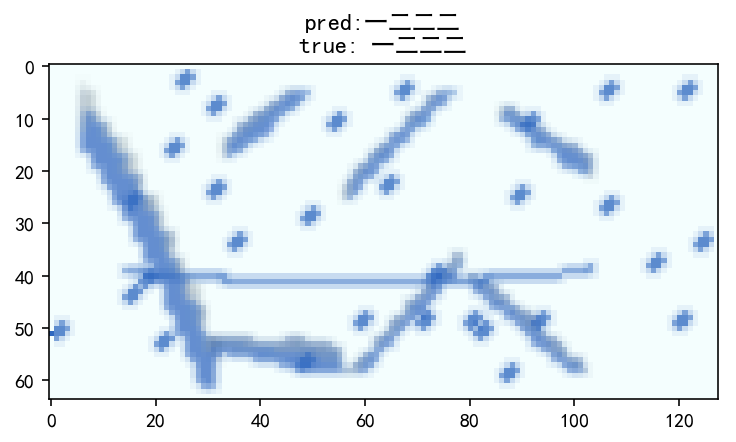

In [14]:
characters2 = characters + ' '
[X_test, y_test, _, _], _  = data[0]
y_pred = base_model.predict(X_test)
out = K.get_value(K.ctc_decode(y_pred, input_length=np.ones(y_pred.shape[0])*y_pred.shape[1], )[0][0])[:, :4]
out = ''.join([characters[x] for x in out[0]])
y_true = ''.join([characters[x] for x in y_test[0]])

plt.imshow(X_test[0])
plt.title('pred:' + str(out) + '\ntrue: ' + str(y_true))

argmax = np.argmax(y_pred, axis=2)[0]

## 第二部分(crnn做随机抽取keys中20来个字的模型)

In [15]:
characters = '绚诚娇溜题贿者廖更纳加奉公一就汴计与路房原天上地下数据自动生成器'
width, height, n_len, n_class = 128, 64, 4, len(characters) + 1

In [16]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

input_tensor = Input((height, width, 3))
x = input_tensor
for i, n_cnn in enumerate([2, 2, 2, 2, 2]):
    for j in range(n_cnn):
        x = Conv2D(32*2**min(i, 3), kernel_size=3, padding='same', kernel_initializer='he_uniform')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
    x = MaxPooling2D(2 if i < 3 else (2, 1))(x)

x = Permute((2, 1, 3))(x)
x = TimeDistributed(Flatten())(x)

rnn_size = 128
x = Bidirectional(CuDNNGRU(rnn_size, return_sequences=True))(x)
x = Bidirectional(CuDNNGRU(rnn_size, return_sequences=True))(x)
x = Dense(n_class, activation='softmax')(x)

base_model = Model(inputs=input_tensor, outputs=x)

In [17]:
labels = Input(name='the_labels', shape=[n_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([x, labels, input_length, label_length])

model = Model(inputs=[input_tensor, labels, input_length, label_length], outputs=loss_out)

In [18]:
from tensorflow.keras.utils import Sequence

class CaptchaSequence(Sequence):
    def __init__(self, characters, batch_size, steps, n_len, width=128, height=64, 
                 input_length=16, label_length=4):
        self.characters = characters
        self.batch_size = batch_size
        self.steps = steps
        self.n_len = n_len
        self.width = width
        self.height = height
        self.input_length = input_length
        self.label_length = label_length
        self.n_class = len(characters)
        self.generator = ImageCaptcha(width=width, height=height,fonts=ziti)
    
    def __len__(self):
        return self.steps

    def __getitem__(self, idx):
        X = np.zeros((self.batch_size, self.height, self.width, 3), dtype=np.float32)
        y = np.zeros((self.batch_size, self.n_len), dtype=np.uint8)
        input_length = np.ones(self.batch_size)*self.input_length
        label_length = np.ones(self.batch_size)*self.label_length
        for i in range(self.batch_size):
            random_str = ''.join([random.choice(self.characters) for j in range(self.n_len)])
            X[i] = np.array(self.generator.generate_image(random_str)) / 255.0
            y[i] = [self.characters.find(x) for x in random_str]
        return [X, y, input_length, label_length], np.ones(self.batch_size)

Tensor("input_length_1:0", shape=(?, 1), dtype=int64) Tensor("label_length_1:0", shape=(?, 1), dtype=int64)


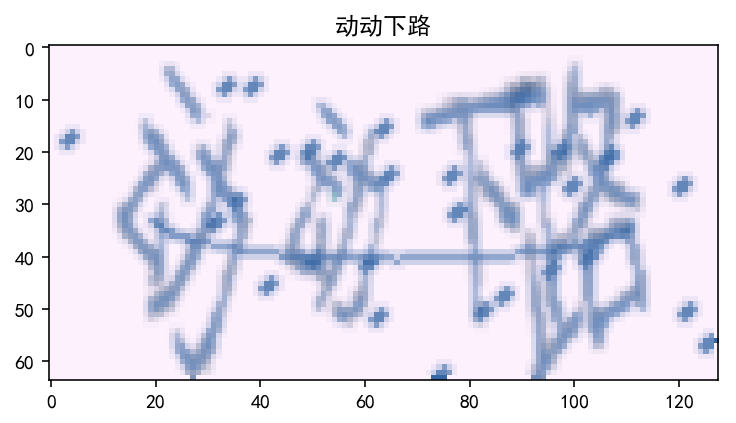

In [19]:
ziti = ['msyhl.ttc']
data = CaptchaSequence(characters, batch_size=1, steps=1,n_len=n_len)
[X_test, y_test, _, _], _  = data[0]
plt.imshow(X_test[0])
plt.title(''.join([characters[x] for x in y_test[0]]))
print(input_length, label_length)

In [20]:
from tqdm import tqdm

def evaluate(model, batch_size=128, steps=20,n_len=n_len):
    batch_acc = 0
    valid_data = CaptchaSequence(characters, batch_size, steps,n_len)
    for [X_test, y_test, _, _], _ in valid_data:
        y_pred = base_model.predict(X_test)
        shape = y_pred.shape
        out = K.get_value(K.ctc_decode(y_pred, input_length=np.ones(shape[0])*shape[1])[0][0])[:, :4]
        if out.shape[1] == 4:
            batch_acc += (y_test == out).all(axis=1).mean()
    return batch_acc / steps

In [21]:
from tensorflow.keras.callbacks import Callback

class Evaluate(Callback):
    def __init__(self):
        self.accs = []
    
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        acc = evaluate(base_model)
        logs['val_acc'] = acc
        self.accs.append(acc)

In [22]:
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from tensorflow.keras.optimizers import *

train_data = CaptchaSequence(characters, batch_size=128, steps=1000,n_len=n_len)
valid_data = CaptchaSequence(characters, batch_size=128, steps=100,n_len=n_len)
callbacks = [EarlyStopping(monitor='val_loss',min_delta=0.001,patience=3), Evaluate()]

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(1e-3, amsgrad=True))
model.fit_generator(train_data, epochs=5, validation_data=valid_data, workers=4, use_multiprocessing=True,
                    callbacks=callbacks)

Epoch 1/5
1000/1000 [==============================] - 230s 230ms/step - loss: 2.3548 - val_loss: 0.5270
Epoch 2/5
1000/1000 [==============================] - 226s 226ms/step - loss: 0.0672 - val_loss: 0.0918
Epoch 3/5
1000/1000 [==============================] - 227s 227ms/step - loss: 0.0308 - val_loss: 0.0500
Epoch 4/5
1000/1000 [==============================] - 225s 225ms/step - loss: 0.0189 - val_loss: 0.2868
Epoch 5/5
1000/1000 [==============================] - 229s 229ms/step - loss: 0.0115 - val_loss: 0.0515


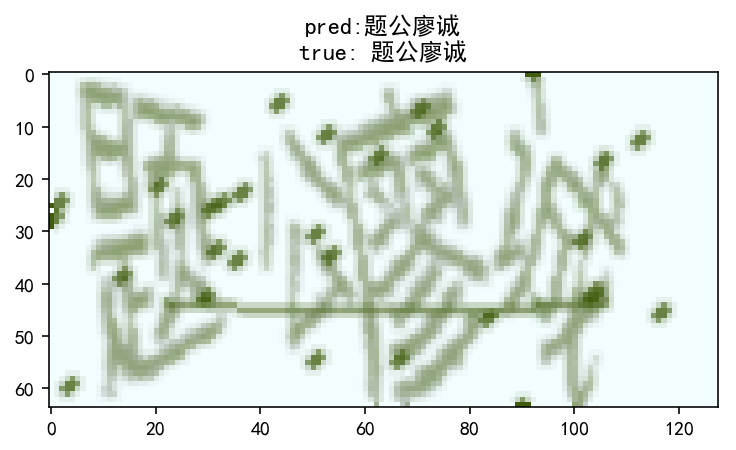

In [23]:
characters2 = characters + ' '
[X_test, y_test, _, _], _  = data[0]
y_pred = base_model.predict(X_test)
out = K.get_value(K.ctc_decode(y_pred, input_length=np.ones(y_pred.shape[0])*y_pred.shape[1], )[0][0])[:, :4]
out_one = ''.join([characters[x] for x in out[0]])
y_true = ''.join([characters[x] for x in y_test[0]])

plt.imshow(X_test[0])
plt.title('pred:' + str(out_one) + '\ntrue: ' + str(y_true))
argmax = np.argmax(y_pred, axis=2)[0]

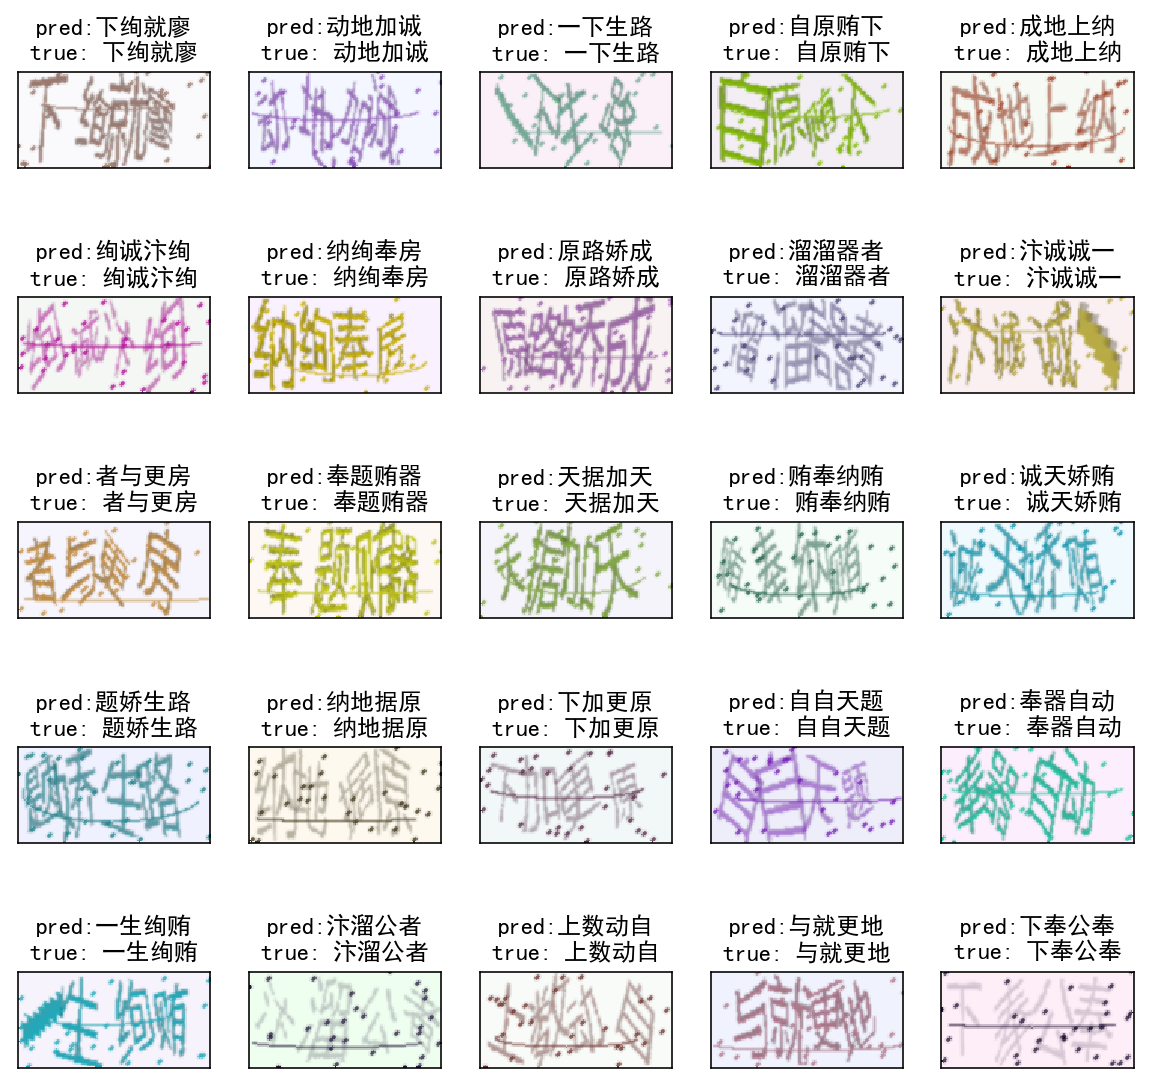

In [24]:
data = CaptchaSequence(characters, batch_size=25, steps=1,n_len=n_len)
[X_test, y_test, _, _], _  = data[0]
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    y_pred = base_model.predict(X_test)
    out = K.get_value(K.ctc_decode(y_pred, input_length=np.ones(y_pred.shape[0])*y_pred.shape[1], )[0][0])[:, :4]
    out_one = ''.join([characters[x] for x in out[i]])
    y_true = ''.join([characters[x] for x in y_test[i]])
    plt.imshow(X_test[i])
    plt.title('pred:' + str(out_one) + '\ntrue: ' + str(y_true))
    plt.xticks([])
    plt.yticks([])

## 效果不错，那接上我们的整个keys数据集

## 第三部分(crnn做从keys中挑选255个汉字的模型)

In [25]:
import keys
characters = keys.alphabet[1:255]

In [26]:
width, height, n_len, n_class = 128, 64, 4, len(characters) + 1

In [27]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

input_tensor = Input((height, width, 3))
x = input_tensor
for i, n_cnn in enumerate([2, 2, 2, 2, 2]):
    for j in range(n_cnn):
        x = Conv2D(32*2**min(i, 3), kernel_size=3, padding='same', kernel_initializer='he_uniform')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
    x = MaxPooling2D(2 if i < 3 else (2, 1))(x)

x = Permute((2, 1, 3))(x)
x = TimeDistributed(Flatten())(x)

rnn_size = 128
x = Bidirectional(CuDNNGRU(rnn_size, return_sequences=True))(x)
x = Bidirectional(CuDNNGRU(rnn_size, return_sequences=True))(x)
x = Dense(n_class, activation='softmax')(x)

base_model = Model(inputs=input_tensor, outputs=x)

In [28]:
labels = Input(name='the_labels', shape=[n_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([x, labels, input_length, label_length])

model = Model(inputs=[input_tensor, labels, input_length, label_length], outputs=loss_out)

In [29]:
from tensorflow.keras.utils import Sequence

class CaptchaSequence(Sequence):
    def __init__(self, characters, batch_size, steps, n_len, width=128, height=64, 
                 input_length=16, label_length=4):
        self.characters = characters
        self.batch_size = batch_size
        self.steps = steps
        self.n_len = n_len
        self.width = width
        self.height = height
        self.input_length = input_length
        self.label_length = label_length
        self.n_class = len(characters)
        self.generator = ImageCaptcha(width=width, height=height,fonts=ziti)
    
    def __len__(self):
        return self.steps

    def __getitem__(self, idx):
        X = np.zeros((self.batch_size, self.height, self.width, 3), dtype=np.float32)
        y = np.zeros((self.batch_size, self.n_len), dtype=np.uint8)
        input_length = np.ones(self.batch_size)*self.input_length
        label_length = np.ones(self.batch_size)*self.label_length
        for i in range(self.batch_size):
            random_str = ''.join([random.choice(self.characters) for j in range(self.n_len)])
            X[i] = np.array(self.generator.generate_image(random_str)) / 255.0
            y[i] = [self.characters.find(x) for x in random_str]
        return [X, y, input_length, label_length], np.ones(self.batch_size)

Tensor("input_length_2:0", shape=(?, 1), dtype=int64) Tensor("label_length_2:0", shape=(?, 1), dtype=int64)


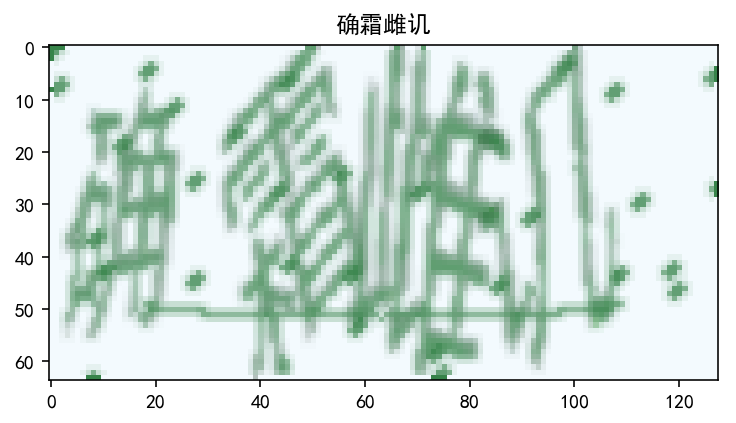

In [30]:
ziti = ['msyhl.ttc']
data = CaptchaSequence(characters, batch_size=2, steps=1,n_len=n_len)
[X_test, y_test, _, _], _  = data[0]
plt.imshow(X_test[0])
plt.title(''.join([characters[x] for x in y_test[0]]))
print(input_length, label_length)

In [31]:
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from tensorflow.keras.optimizers import *

train_data = CaptchaSequence(characters, batch_size=128, steps=1000,n_len=n_len)
valid_data = CaptchaSequence(characters, batch_size=128, steps=100,n_len=n_len)
callbacks = [EarlyStopping(monitor='val_loss',min_delta=0.001,patience=3), Evaluate()]


model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(1e-3, amsgrad=True))
model.fit_generator(train_data, epochs=4, validation_data=valid_data, workers=4, use_multiprocessing=True,
                    callbacks=callbacks)

Epoch 1/4
1000/1000 [==============================] - 247s 247ms/step - loss: 15.5564 - val_loss: 20.2168
Epoch 2/4
1000/1000 [==============================] - 239s 239ms/step - loss: 2.7626 - val_loss: 2.3934
Epoch 3/4
1000/1000 [==============================] - 243s 243ms/step - loss: 0.9524 - val_loss: 13.5483
Epoch 4/4
1000/1000 [==============================] - 241s 241ms/step - loss: 0.5669 - val_loss: 1.2579


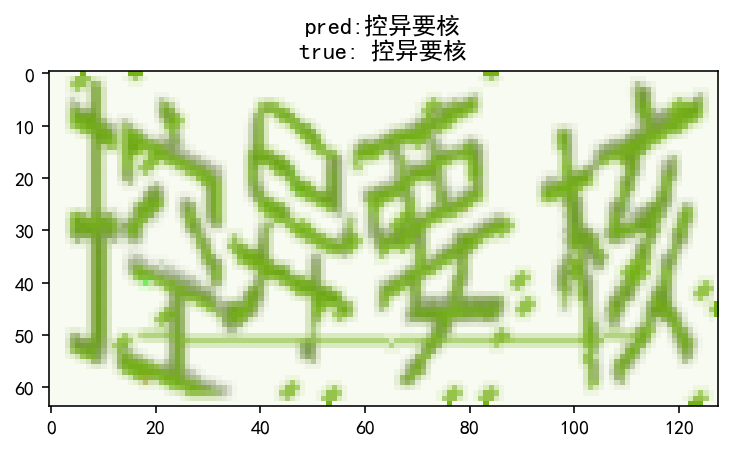

In [32]:
characters2 = characters + ' '
[X_test, y_test, _, _], _  = data[0]
y_pred = base_model.predict(X_test)
out = K.get_value(K.ctc_decode(y_pred, input_length=np.ones(y_pred.shape[0])*y_pred.shape[1], )[0][0])[:, :4]
out_one = ''.join([characters[x] for x in out[0]])
y_true = ''.join([characters[x] for x in y_test[0]])

plt.imshow(X_test[0])
plt.title('pred:' + str(out_one) + '\ntrue: ' + str(y_true))

argmax = np.argmax(y_pred, axis=2)[0]

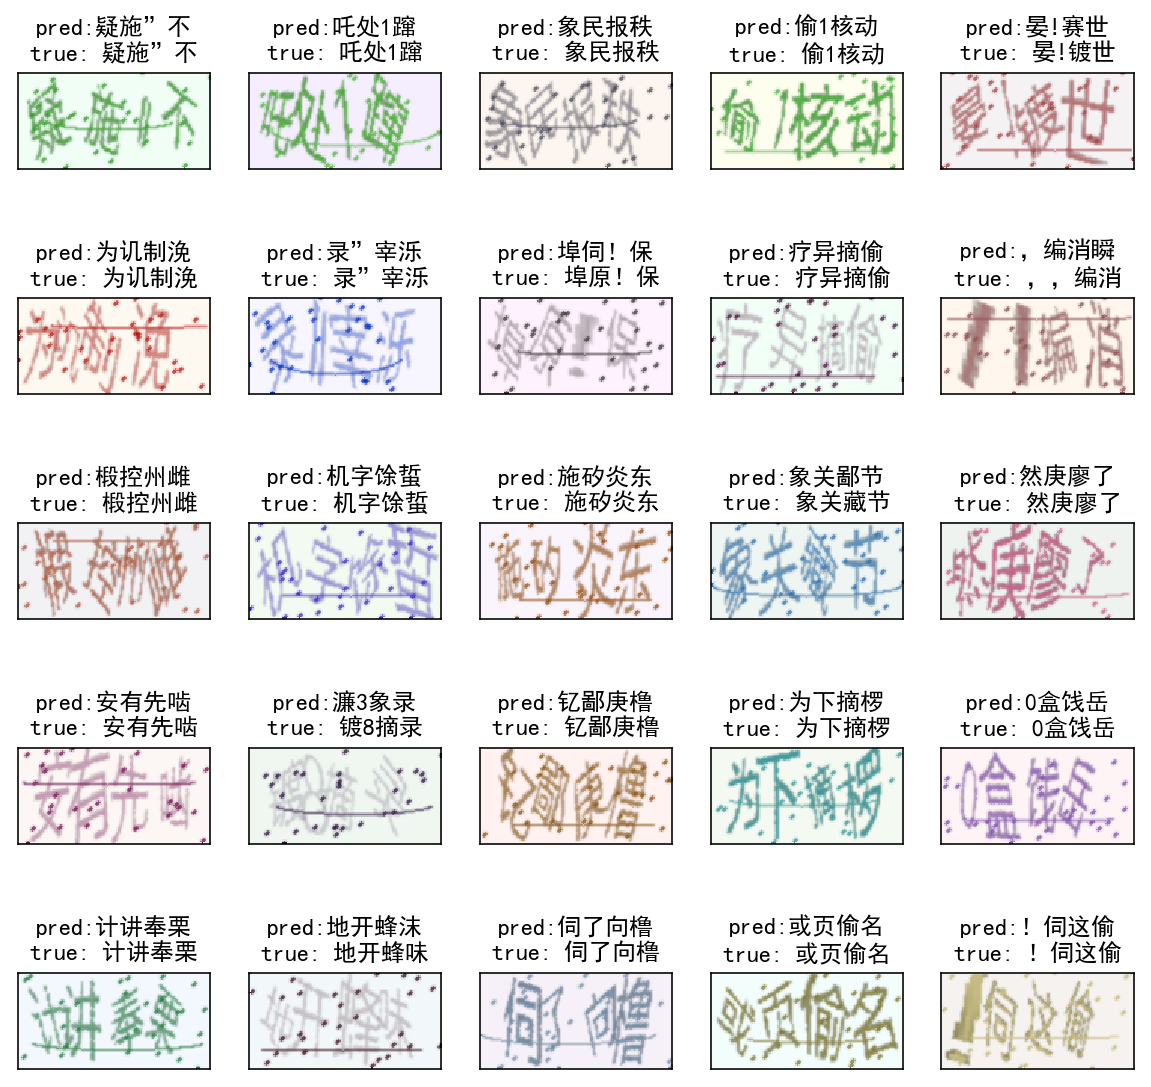

In [34]:
data = CaptchaSequence(characters, batch_size=25, steps=1,n_len=n_len)
[X_test, y_test, _, _], _  = data[0]
plt.figure(figsize=(10,10))
y_pred = base_model.predict(X_test)
out = K.get_value(K.ctc_decode(y_pred, input_length=np.ones(y_pred.shape[0])*y_pred.shape[1], )[0][0])[:, :4]
for i in range(25):
    plt.subplot(5,5,i+1)
    out_one = ''.join([characters[x] for x in out[i]])
    y_true = ''.join([characters[x] for x in y_test[i]])
    plt.imshow(X_test[i])
    plt.title('pred:' + str(out_one) + '\ntrue: ' + str(y_true))
    plt.xticks([])
    plt.yticks([])

In [33]:
data = CaptchaSequence(characters, batch_size=100, steps=1,n_len=n_len)
[X_test, y_test, _, _], _  = data[0]
y_pred = base_model.predict(X_test)
acc = 0
out = K.get_value(K.ctc_decode(y_pred, input_length=np.ones(y_pred.shape[0])*y_pred.shape[1], )[0][0])[:, :4]
for i in range(100):
    out_one = ''.join([characters[x] for x in out[i]])
    y_true = ''.join([characters[x] for x in y_test[i]])
    if(out_one==y_true):
        acc = acc+1
print('准确率为:{}%'.format(acc))

    
    

准确率为:85%


In [ ]:
##以上为crnn模型训练5轮的准确性